In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from password import password

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
protocol = 'postgresql'
username = 'postgres'
password = password
host = 'localhost'
port = 5432
database_name = 'churn_pred'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
connection = engine.connect()

In [3]:
df = pd.read_sql("SELECT * FROM fact_churn", connection)
df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,1,0,0,1
1,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0,0,1,1,0
2,62,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,0,1,0,0,0
3,93,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,1,0,1,0,0
4,174,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,1,1,0,0,0


In [14]:
# Split the data into X_train, X_test, y_train, y_test
X = df.drop(['churn'], axis=1)
y = df['churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.25)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X.sample(5)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
72,113,0,239.7,47,40.75,282.9,110,24.05,238.4,88,10.73,8.7,3,2.35,2,1,0,0,0
3206,78,0,108.6,108,18.46,209.9,126,17.84,222.6,117,10.02,7.9,5,2.13,1,0,0,0,0
4093,42,0,260.9,94,44.35,152.8,123,12.99,212.6,94,9.57,11.1,4,3.00,1,0,1,1,0
4564,116,0,179.0,81,30.43,200.0,116,17.00,168.6,74,7.59,15.8,7,4.27,1,0,1,0,0
3621,61,0,208.4,102,35.43,326.1,96,27.72,201.9,73,9.09,10.1,8,2.73,1,0,0,0,0


In [24]:
# Train a Logistic Regression model print the model score
log = LogisticRegression(max_iter=10000, solver='saga', penalty='elasticnet', l1_ratio=0.9)
log.fit(X_train_scaled, y_train)

print(f"Training Data Score: {log.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {log.score(X_test_scaled, y_test)}")

Training Data Score: 0.8325333333333333
Testing Data Score: 0.8128


In [25]:
y_pred = log.predict(X_test_scaled)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[988,  25],
       [209,  28]])

Text(0.5, 257.44, 'Predicted label')

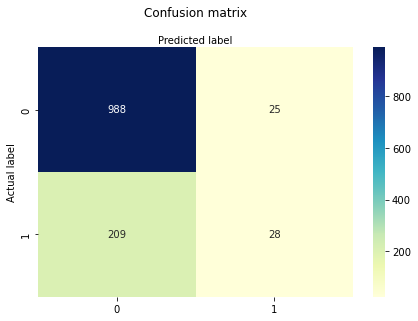

In [26]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Text(0.5,257.44,'Predicted label');

In [27]:
target_names = ['churn: no', 'churn: yes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   churn: no       0.83      0.98      0.89      1013
  churn: yes       0.53      0.12      0.19       237

    accuracy                           0.81      1250
   macro avg       0.68      0.55      0.54      1250
weighted avg       0.77      0.81      0.76      1250



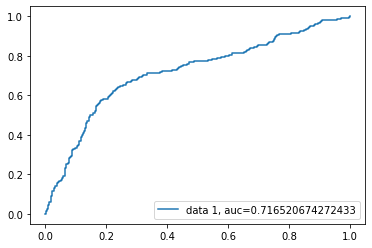

In [28]:
y_pred_proba = log.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()